In [31]:
import datetime
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
import hopsworks
import requests
import matplotlib.pyplot as plt
import joblib
import json

today = datetime.datetime.now()
print(f"Inference date: {today}")

Inference date: 2026-01-02 20:46:41.438826


## <span style='color:#ff5f27'> Imports

# <span style="font-width:bold; font-size: 3rem; color:#333;">Batch Inference Pipeline</span>

In [32]:
import sys
from pathlib import Path
import os

def is_google_colab() -> bool:
    if "google.colab" in str(get_ipython()):
        return True
    return False

def clone_repository() -> None:
    !git clone https://github.com/featurestorebook/mlfs-book.git
    %cd mlfs-book

def install_dependencies() -> None:
    !pip install --upgrade uv
    !uv pip install --all-extras --system --requirement pyproject.toml

if is_google_colab():
    clone_repository()
    install_dependencies()
    root_dir = str(Path().absolute())
    print("Google Colab environment")
else:
    root_dir = Path().absolute()
    # Strip ~/notebooks/fingrid from PYTHON_PATH if notebook started in one of these subdirectories
    if root_dir.parts[-1:] == ('notebooks',):
        root_dir = Path(*root_dir.parts[:-1])
    if root_dir.parts[-1:] == ('fingrid',):
        root_dir = Path(*root_dir.parts[:-1])
    root_dir = str(root_dir) 
    print("Local environment")

# Add the root directory to the `PYTHONPATH`
if root_dir not in sys.path:
    sys.path.append(root_dir)
print(f"Added the following directory to the PYTHONPATH: {root_dir}")
    
# Set the environment variables from the file <root_dir>/.env (if running locally)
# In GitHub Actions, environment variables are already set
if os.path.exists(f"{root_dir}/.env"):
    from mlfs import config
    settings = config.HopsworksSettings(_env_file=f"{root_dir}/.env")
else:
    # GitHub Actions environment - settings not needed
    settings = None

Local environment
Added the following directory to the PYTHONPATH: c:\Users\patri\VScodeProjects\25-ID2223-mlfs-book
HopsworksSettings initialized!


## <span style="color:#ff5f27;"> Connect to Hopsworks Feature Store </span>

In [33]:
project = hopsworks.login()
fs = project.get_feature_store()
mr = project.get_model_registry()

secrets = hopsworks.get_secrets_api()
location_str = secrets.get_secret("FINGRID_LOCATION_JSON").value
location = json.loads(location_str)

country = location['country']
city = location['city']

2026-01-02 20:46:41,697 INFO: Closing external client and cleaning up certificates.
Connection closed.
2026-01-02 20:46:41,718 INFO: Initializing external client
2026-01-02 20:46:41,720 INFO: Base URL: https://c.app.hopsworks.ai:443
2026-01-02 20:46:43,361 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1286359


## <span style="color:#ff5f27;">Download the model from Model Registry</span>

In [ ]:
# Load the model from local directory
model_path = f"{root_dir}/fingrid/energy_model/energy_consumption_predictor.pkl"
retrieved_xgboost_model = joblib.load(model_path)

print(f"Model loaded from: {model_path}")
retrieved_xgboost_model

FileNotFoundError: [Errno 2] No such file or directory: 'c:\\Users\\patri\\VScodeProjects\\25-ID2223-mlfs-book/energy_model/energy_consumption_predictor.pkl'

## <span style="color:#ff5f27;">Get Weather Forecast Features</span>

In [ ]:
# Get future weather forecast data (matching airquality pattern)
weather_fg = fs.get_feature_group(
    name='weather_finland',
    version=1,
)
# Get 7 days of FUTURE forecast starting from today
# Read all recent data and filter in pandas to avoid timezone issues
batch_data = weather_fg.read()

# Ensure timezone-naive for filtering
if batch_data['date'].dt.tz is not None:
    batch_data['date'] = batch_data['date'].dt.tz_localize(None)

# Filter for next 7 days
start_date = pd.Timestamp(today.date())
end_date = start_date + pd.Timedelta(days=7)
batch_data = batch_data[
    (batch_data['date'] >= start_date) & (batch_data['date'] < end_date)
].copy()

print(f"Weather forecast data: {len(batch_data)} rows from {start_date.date()} to {end_date.date()}")
print(f"Date range: {batch_data['date'].min()} to {batch_data['date'].max()}")
print(f"Unique days: {batch_data['date'].dt.date.nunique()}")
batch_data.head()

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.22s) 
Weather forecast data: 56 rows from 2026-01-02 to 2026-01-09
Date range: 2026-01-02 00:00:00 to 2026-01-08 21:00:00
Unique days: 7


,date,temperature_2m,precipitation,cloud_cover,wind_speed_10m,wind_speed_100m,wind_direction_10m,surface_pressure,shortwave_radiation,country
5848,2026-01-07 06:00:00,-4.333333,0.9,100.000000,15.233333,24.133333,65.666667,1017.233333,0.000000,Finland
5849,2026-01-07 18:00:00,-10.100000,0.0,78.666667,11.566667,20.600000,26.666667,1022.333333,0.000000,Finland
5850,2026-01-04 21:00:00,-10.466667,0.0,85.000000,22.200000,30.366667,29.000000,1004.066667,0.000000,Finland
5851,2026-01-02 12:00:00,-3.366667,0.3,100.000000,37.433333,39.633333,105.333333,984.633333,11.666667,Finland
5852,2026-01-02 06:00:00,-4.033333,0.8,100.000000,37.666667,39.200000,108.333333,983.733333,0.000000,Finland


In [ ]:
# Diagnose weather forecast data
print(f"Total rows fetched: {len(batch_data)}")
print(f"Date range in weather data: {batch_data['date'].min()} to {batch_data['date'].max()}")
print(f"Unique dates: {batch_data['date'].dt.date.nunique()}")

print(f"\nRows per date:")
print(batch_data['date'].dt.date.value_counts().sort_index())

print(f"\nFirst few rows:")
print(batch_data[['date', 'temperature_2m', 'wind_speed_10m']].head(20))

Total rows fetched: 56
Date range in weather data: 2026-01-02 00:00:00 to 2026-01-08 21:00:00
Unique dates: 7

Rows per date:
date
2026-01-02    8
2026-01-03    8
2026-01-04    8
2026-01-05    8
2026-01-06    8
2026-01-07    8
2026-01-08    8
Name: count, dtype: int64

First few rows:
                    date  temperature_2m  wind_speed_10m
5848 2026-01-07 06:00:00       -4.333333       15.233333
5849 2026-01-07 18:00:00      -10.100000       11.566667
5850 2026-01-04 21:00:00      -10.466667       22.200000
5851 2026-01-02 12:00:00       -3.366667       37.433333
5852 2026-01-02 06:00:00       -4.033333       37.666667
5853 2026-01-04 03:00:00       -7.700000       20.066667
5854 2026-01-05 09:00:00      -16.566667       11.866667
5855 2026-01-02 00:00:00       -3.600000       38.533333
5856 2026-01-06 18:00:00       -2.100000       15.133333
5857 2026-01-08 15:00:00       -4.066667       12.700000
5858 2026-01-07 00:00:00       -2.900000       11.866667
5859 2026-01-04 15:00:00      

### <span style="color:#ff5f27;">Add Temporal Features</span>

In [ ]:
# Add temporal features to forecast data
batch_data['year'] = batch_data['date'].dt.year
batch_data['month'] = batch_data['date'].dt.month
batch_data['day'] = batch_data['date'].dt.day
batch_data['hour'] = batch_data['date'].dt.hour
batch_data['day_of_week'] = batch_data['date'].dt.dayofweek
batch_data['is_weekend'] = (batch_data['day_of_week'] >= 5).astype(int)
batch_data['week_of_year'] = batch_data['date'].dt.isocalendar().week

print("Features created:")
print(batch_data.columns.tolist())
batch_data.head()

Features created:
['date', 'temperature_2m', 'precipitation', 'cloud_cover', 'wind_speed_10m', 'wind_speed_100m', 'wind_direction_10m', 'surface_pressure', 'shortwave_radiation', 'country', 'year', 'month', 'day', 'hour', 'day_of_week', 'is_weekend', 'week_of_year']


,date,temperature_2m,precipitation,cloud_cover,wind_speed_10m,wind_speed_100m,wind_direction_10m,surface_pressure,shortwave_radiation,country,year,month,day,hour,day_of_week,is_weekend,week_of_year
5848,2026-01-07 06:00:00,-4.333333,0.9,100.000000,15.233333,24.133333,65.666667,1017.233333,0.000000,Finland,2026,1,7,6,2,0,2
5849,2026-01-07 18:00:00,-10.100000,0.0,78.666667,11.566667,20.600000,26.666667,1022.333333,0.000000,Finland,2026,1,7,18,2,0,2
5850,2026-01-04 21:00:00,-10.466667,0.0,85.000000,22.200000,30.366667,29.000000,1004.066667,0.000000,Finland,2026,1,4,21,6,1,1
5851,2026-01-02 12:00:00,-3.366667,0.3,100.000000,37.433333,39.633333,105.333333,984.633333,11.666667,Finland,2026,1,2,12,4,0,1
5852,2026-01-02 06:00:00,-4.033333,0.8,100.000000,37.666667,39.200000,108.333333,983.733333,0.000000,Finland,2026,1,2,6,4,0,1


### <span style="color:#ff5f27;">Add Cyclic Features</span>

Convert temporal features to cyclic encoding (matching training pipeline)

In [ ]:
# Add cyclic encoding for month (12 months in a year)
batch_data['month_sin'] = np.sin(2 * np.pi * batch_data['month'] / 12)
batch_data['month_cos'] = np.cos(2 * np.pi * batch_data['month'] / 12)

# Add cyclic encoding for hour (24 hours in a day)
batch_data['hour_sin'] = np.sin(2 * np.pi * batch_data['hour'] / 24)
batch_data['hour_cos'] = np.cos(2 * np.pi * batch_data['hour'] / 24)

# Add cyclic encoding for day_of_week (7 days in a week)
batch_data['day_of_week_sin'] = np.sin(2 * np.pi * batch_data['day_of_week'] / 7)
batch_data['day_of_week_cos'] = np.cos(2 * np.pi * batch_data['day_of_week'] / 7)

print("Cyclic features added")
batch_data.head()

Cyclic features added


,date,temperature_2m,precipitation,cloud_cover,wind_speed_10m,wind_speed_100m,wind_direction_10m,surface_pressure,shortwave_radiation,country,...,hour,day_of_week,is_weekend,week_of_year,month_sin,month_cos,hour_sin,hour_cos,day_of_week_sin,day_of_week_cos
5848,2026-01-07 06:00:00,-4.333333,0.9,100.000000,15.233333,24.133333,65.666667,1017.233333,0.000000,Finland,...,6,2,0,2,0.5,0.866025,1.000000e+00,6.123234e-17,0.974928,-0.222521
5849,2026-01-07 18:00:00,-10.100000,0.0,78.666667,11.566667,20.600000,26.666667,1022.333333,0.000000,Finland,...,18,2,0,2,0.5,0.866025,-1.000000e+00,-1.836970e-16,0.974928,-0.222521
5850,2026-01-04 21:00:00,-10.466667,0.0,85.000000,22.200000,30.366667,29.000000,1004.066667,0.000000,Finland,...,21,6,1,1,0.5,0.866025,-7.071068e-01,7.071068e-01,-0.781831,0.623490
5851,2026-01-02 12:00:00,-3.366667,0.3,100.000000,37.433333,39.633333,105.333333,984.633333,11.666667,Finland,...,12,4,0,1,0.5,0.866025,1.224647e-16,-1.000000e+00,-0.433884,-0.900969
5852,2026-01-02 06:00:00,-4.033333,0.8,100.000000,37.666667,39.200000,108.333333,983.733333,0.000000,Finland,...,6,4,0,1,0.5,0.866025,1.000000e+00,6.123234e-17,-0.433884,-0.900969


### <span style="color:#ff5f27;">Making the predictions</span>

In [ ]:
# Drop columns not used for prediction (including original cyclic features)
cols_to_drop = [col for col in ['consumption', 'date', 'country', 'month', 'hour', 'day_of_week'] if col in batch_data.columns]
X_pred = batch_data.drop(columns=cols_to_drop)

# Reorder columns to match the training data order
expected_order = ['year', 'day', 'is_weekend', 'week_of_year', 
                  'temperature_2m', 'precipitation', 'cloud_cover', 
                  'wind_speed_10m', 'wind_speed_100m', 'wind_direction_10m', 
                  'surface_pressure', 'shortwave_radiation',
                  'month_sin', 'month_cos', 'hour_sin', 'hour_cos', 
                  'day_of_week_sin', 'day_of_week_cos']

# Only use columns that exist in both lists
X_pred = X_pred[[col for col in expected_order if col in X_pred.columns]]

print(f"Dropped columns: {cols_to_drop}")
print(f"Features for prediction: {list(X_pred.columns)}")

# Make predictions
batch_data['predicted_consumption'] = retrieved_xgboost_model.predict(X_pred)
batch_data

Dropped columns: ['date', 'country', 'month', 'hour', 'day_of_week']
Features for prediction: ['year', 'day', 'is_weekend', 'week_of_year', 'temperature_2m', 'precipitation', 'cloud_cover', 'wind_speed_10m', 'wind_speed_100m', 'wind_direction_10m', 'surface_pressure', 'shortwave_radiation', 'month_sin', 'month_cos', 'hour_sin', 'hour_cos', 'day_of_week_sin', 'day_of_week_cos']


,date,temperature_2m,precipitation,cloud_cover,wind_speed_10m,wind_speed_100m,wind_direction_10m,surface_pressure,shortwave_radiation,country,...,day_of_week,is_weekend,week_of_year,month_sin,month_cos,hour_sin,hour_cos,day_of_week_sin,day_of_week_cos,predicted_consumption
5848,2026-01-07 06:00:00,-4.333333,0.9,100.000000,15.233333,24.133333,65.666667,1017.233333,0.000000,Finland,...,2,0,2,0.5,0.866025,1.000000e+00,6.123234e-17,0.974928,-0.222521,12101.288086
5849,2026-01-07 18:00:00,-10.100000,0.0,78.666667,11.566667,20.600000,26.666667,1022.333333,0.000000,Finland,...,2,0,2,0.5,0.866025,-1.000000e+00,-1.836970e-16,0.974928,-0.222521,12318.360352
5850,2026-01-04 21:00:00,-10.466667,0.0,85.000000,22.200000,30.366667,29.000000,1004.066667,0.000000,Finland,...,6,1,1,0.5,0.866025,-7.071068e-01,7.071068e-01,-0.781831,0.623490,11947.143555
5851,2026-01-02 12:00:00,-3.366667,0.3,100.000000,37.433333,39.633333,105.333333,984.633333,11.666667,Finland,...,4,0,1,0.5,0.866025,1.224647e-16,-1.000000e+00,-0.433884,-0.900969,11788.803711
5852,2026-01-02 06:00:00,-4.033333,0.8,100.000000,37.666667,39.200000,108.333333,983.733333,0.000000,Finland,...,4,0,1,0.5,0.866025,1.000000e+00,6.123234e-17,-0.433884,-0.900969,12290.591797
5853,2026-01-04 03:00:00,-7.700000,0.0,100.000000,20.066667,31.000000,37.000000,995.666667,0.000000,Finland,...,6,1,1,0.5,0.866025,7.071068e-01,7.071068e-01,-0.781831,0.623490,11423.040039
5854,2026-01-05 09:00:00,-16.566667,0.0,38.000000,11.866667,21.133333,4.666667,1011.866667,17.333333,Finland,...,0,0,2,0.5,0.866025,7.071068e-01,-7.071068e-01,0.000000,1.000000,13065.413086
5855,2026-01-02 00:00:00,-3.600000,0.0,100.000000,38.533333,39.533333,112.000000,985.133333,0.000000,Finland,...,4,0,1,0.5,0.866025,0.000000e+00,1.000000e+00,-0.433884,-0.900969,10562.283203
5856,2026-01-06 18:00:00,-2.100000,0.9,100.000000,15.133333,23.200000,143.666667,1015.800000,0.000000,Finland,...,1,0,2,0.5,0.866025,-1.000000e+00,-1.836970e-16,0.781831,0.623490,11858.524414
5857,2026-01-08 15:00:00,-4.066667,0.0,100.000000,12.700000,19.433333,170.333333,1026.733333,11.666667,Finland,...,3,0,2,0.5,0.866025,-7.071068e-01,-7.071068e-01,0.433884,-0.900969,12507.547852


In [ ]:
batch_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 56 entries, 5848 to 5903
Data columns (total 24 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   date                   56 non-null     datetime64[us]
 1   temperature_2m         56 non-null     float64       
 2   precipitation          56 non-null     float64       
 3   cloud_cover            56 non-null     float64       
 4   wind_speed_10m         56 non-null     float64       
 5   wind_speed_100m        56 non-null     float64       
 6   wind_direction_10m     56 non-null     float64       
 7   surface_pressure       56 non-null     float64       
 8   shortwave_radiation    56 non-null     float64       
 9   country                56 non-null     object        
 10  year                   56 non-null     int32         
 11  month                  56 non-null     int32         
 12  day                    56 non-null     int32         
 13  hour   

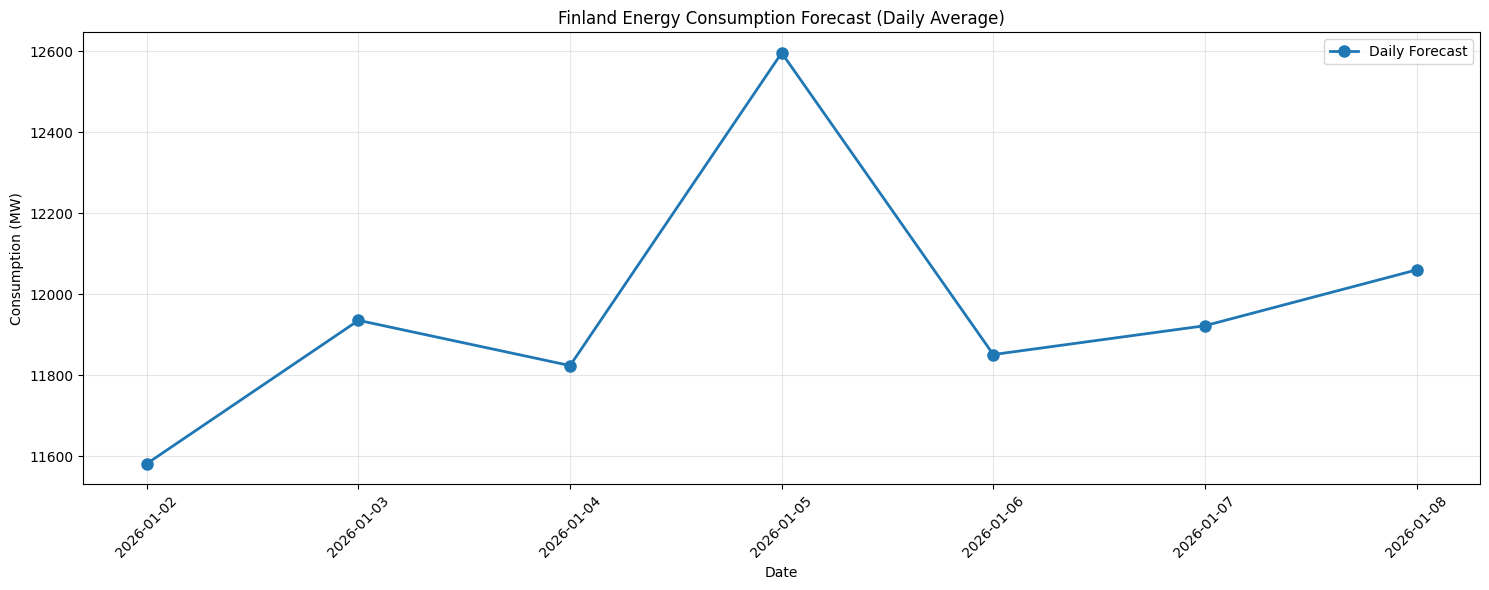

Forecast saved to: c:\Users\patri\VScodeProjects\25-ID2223-mlfs-book\fingrid/docs/fingrid/assets/img/energy_forecast.png
Forecasting 7 days


In [ ]:
# Resample to daily averages for cleaner visualization
batch_data['date'] = pd.to_datetime(batch_data['date'])
df_daily = batch_data.set_index('date').resample('D')[['predicted_consumption']].mean().reset_index()

# Plot forecast
plt.figure(figsize=(15, 6))
plt.plot(df_daily['date'], df_daily['predicted_consumption'], 
         linewidth=2, alpha=0.7, label='Daily Forecast')
plt.xlabel('Date')
plt.ylabel('Consumption (MW)')
plt.title('Finland Energy Consumption Forecast (Daily Average)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()

# Save plot
pred_file_path = f"{root_dir}/docs/fingrid/assets/img/energy_forecast.png"
os.makedirs(os.path.dirname(pred_file_path), exist_ok=True)
plt.savefig(pred_file_path, dpi=150, bbox_inches='tight')
plt.show()

print(f"Forecast saved to: {pred_file_path}")
print(f"Forecasting {len(df_daily)} days")

### <span style="color:#ff5f27;">🤖 Saving the predictions (for monitoring) to a Feature Group</span>

In [ ]:
# Add metadata for monitoring
batch_data['country'] = country
batch_data['days_before_forecast_day'] = (batch_data['date'] - pd.Timestamp(today.date())).dt.days
batch_data = batch_data.sort_values(by=['date'])
batch_data

,date,temperature_2m,precipitation,cloud_cover,wind_speed_10m,wind_speed_100m,wind_direction_10m,surface_pressure,shortwave_radiation,country,...,is_weekend,week_of_year,month_sin,month_cos,hour_sin,hour_cos,day_of_week_sin,day_of_week_cos,predicted_consumption,days_before_forecast_day
5855,2026-01-02 00:00:00,-3.600000,0.0,100.000000,38.533333,39.533333,112.000000,985.133333,0.000000,Finland,...,0,1,0.5,0.866025,0.000000e+00,1.000000e+00,-0.433884,-0.900969,10562.283203,0
5884,2026-01-02 03:00:00,-4.100000,0.1,100.000000,37.466667,41.100000,110.666667,984.366667,0.000000,Finland,...,0,1,0.5,0.866025,7.071068e-01,7.071068e-01,-0.433884,-0.900969,10919.387695,0
5852,2026-01-02 06:00:00,-4.033333,0.8,100.000000,37.666667,39.200000,108.333333,983.733333,0.000000,Finland,...,0,1,0.5,0.866025,1.000000e+00,6.123234e-17,-0.433884,-0.900969,12290.591797,0
5881,2026-01-02 09:00:00,-3.800000,0.3,100.000000,37.566667,40.666667,108.333333,984.500000,2.666667,Finland,...,0,1,0.5,0.866025,7.071068e-01,-7.071068e-01,-0.433884,-0.900969,12129.056641,0
5851,2026-01-02 12:00:00,-3.366667,0.3,100.000000,37.433333,39.633333,105.333333,984.633333,11.666667,Finland,...,0,1,0.5,0.866025,1.224647e-16,-1.000000e+00,-0.433884,-0.900969,11788.803711,0
5899,2026-01-02 15:00:00,-3.333333,0.3,100.000000,35.533333,39.633333,107.333333,984.800000,1.333333,Finland,...,0,1,0.5,0.866025,-7.071068e-01,-7.071068e-01,-0.433884,-0.900969,11882.975586,0
5873,2026-01-02 18:00:00,-3.733333,0.8,100.000000,33.700000,38.400000,105.666667,984.966667,0.000000,Finland,...,0,1,0.5,0.866025,-1.000000e+00,-1.836970e-16,-0.433884,-0.900969,11666.220703,0
5872,2026-01-02 21:00:00,-3.300000,0.5,100.000000,32.966667,35.700000,102.000000,985.666667,0.000000,Finland,...,0,1,0.5,0.866025,-7.071068e-01,7.071068e-01,-0.433884,-0.900969,11417.169922,0
5864,2026-01-03 00:00:00,-2.833333,0.8,100.000000,33.133333,35.066667,97.666667,986.633333,0.000000,Finland,...,1,1,0.5,0.866025,0.000000e+00,1.000000e+00,-0.974928,-0.222521,11075.207031,1
5887,2026-01-03 03:00:00,-3.766667,0.7,100.000000,29.666667,35.233333,78.333333,987.366667,0.000000,Finland,...,1,1,0.5,0.866025,7.071068e-01,7.071068e-01,-0.974928,-0.222521,11335.453125,1


In [ ]:
# Get or create monitoring feature group
monitor_fg = fs.get_or_create_feature_group(
    name='energy_predictions',
    description='Energy consumption prediction monitoring',
    version=1,
    primary_key=['country','date','days_before_forecast_day'],
    event_time="date"
)

In [ ]:
# Keep only relevant columns for monitoring
monitoring_data = batch_data[['date', 'country', 'days_before_forecast_day', 'predicted_consumption']].copy()
monitor_fg.insert(monitoring_data, wait=True)
print(f"Inserted {len(monitoring_data)} predictions into monitoring feature group")

Uploading Dataframe: 100.00% |██████████| Rows 56/56 | Elapsed Time: 00:00 | Remaining Time: 00:00


Launching job: energy_predictions_1_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai:443/p/1286359/jobs/named/energy_predictions_1_offline_fg_materialization/executions
2026-01-02 20:11:56,317 INFO: Waiting for execution to finish. Current state: INITIALIZING. Final status: UNDEFINED
2026-01-02 20:11:59,509 INFO: Waiting for execution to finish. Current state: SUBMITTED. Final status: UNDEFINED
2026-01-02 20:12:02,713 INFO: Waiting for execution to finish. Current state: RUNNING. Final status: UNDEFINED
2026-01-02 20:14:20,202 INFO: Waiting for execution to finish. Current state: AGGREGATING_LOGS. Final status: SUCCEEDED
2026-01-02 20:14:20,370 INFO: Waiting for log aggregation to finish.
2026-01-02 20:14:42,477 INFO: Execution finished successfully.
Inserted 56 predictions into monitoring feature group


### <span style="color:#ff5f27;">Create Hindcast - Compare Predictions vs Actual</span>

This shows how well the 1-day-ahead predictions matched actual consumption.

In [ ]:
# Get historical predictions made 1 day before
monitoring_df = monitor_fg.filter(monitor_fg.days_before_forecast_day == 1).read()
print(f"Historical predictions: {len(monitoring_df)} rows")
monitoring_df.head()

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.03s) 
Historical predictions: 11 rows


,date,country,days_before_forecast_day,predicted_consumption
0,2026-01-01 21:00:00+00:00,Finland,1,11331.201172
1,2025-12-31 15:00:00+00:00,Finland,1,12314.262695
2,2026-01-07 06:00:00+00:00,Finland,1,12101.288086
3,2026-01-03 12:00:00+00:00,Finland,1,12229.795898
4,2026-01-03 18:00:00+00:00,Finland,1,12156.563477


In [ ]:
# Get actual energy consumption data
energy_fg = fs.get_feature_group(name='energy_consumption', version=1)
energy_df = energy_fg.read()
print(f"Actual consumption data: {len(energy_df)} rows")
energy_df.head()

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (6.58s) 
Actual consumption data: 383474 rows


,date,consumption_mw,country,year,month,day,hour,day_of_week,is_weekend,week_of_year,consumption_lag_1,consumption_lag_2,consumption_lag_8,consumption_rolling_mean_24h,consumption_rolling_std_24h
0,2024-04-28 02:03:00+00:00,7919.1,Finland,2024,4,28,2,6,1,17,7877.7,7896.3,7742.0,7861.650,44.083687
1,2024-05-09 21:27:00+00:00,8640.3,Finland,2024,5,9,21,3,0,19,8637.2,8582.8,8671.6,8616.300,49.606883
2,2025-06-24 01:54:00+00:00,7126.7,Finland,2025,6,24,1,1,0,26,7098.5,7123.0,7153.6,7138.950,22.355632
3,2024-02-22 08:33:00+00:00,11408.0,Finland,2024,2,22,8,3,0,8,11390.0,11390.0,11285.0,11363.625,41.623954
4,2024-11-29 17:48:00+00:00,10984.0,Finland,2024,11,29,17,4,0,48,11012.0,11024.0,11133.0,11055.000,61.833879


In [ ]:
# Resample actual consumption to daily averages
energy_df['date'] = pd.to_datetime(energy_df['date'])
energy_daily = energy_df.set_index('date').resample('D')[['consumption_mw']].mean().reset_index()
energy_daily = energy_daily.rename(columns={'consumption_mw': 'actual_consumption'})

# Resample predictions to daily averages
if len(monitoring_df) > 0:
    monitoring_df['date'] = pd.to_datetime(monitoring_df['date'])
    preds_daily = monitoring_df.set_index('date').resample('D')[['predicted_consumption']].mean().reset_index()
    
    # Merge predictions with actuals
    hindcast_df = pd.merge(preds_daily, energy_daily, on='date', how='inner')
    hindcast_df = hindcast_df.sort_values(by=['date'])
    print(f"Hindcast data points: {len(hindcast_df)}")
else:
    hindcast_df = pd.DataFrame()
    print("No historical predictions yet for hindcast")

hindcast_df.head()

Hindcast data points: 3


,date,predicted_consumption,actual_consumption
0,2025-12-31 00:00:00+00:00,12314.262695,12771.602083
1,2026-01-01 00:00:00+00:00,11331.201172,13135.481069
2,2026-01-02 00:00:00+00:00,NaN,13315.946809


### <span style="color:#ff5f27;">Plot Hindcast</span>

__This graph will be empty initially - this is normal.__

After a few days of predictions and observations, you will see data points comparing predictions vs actual consumption.

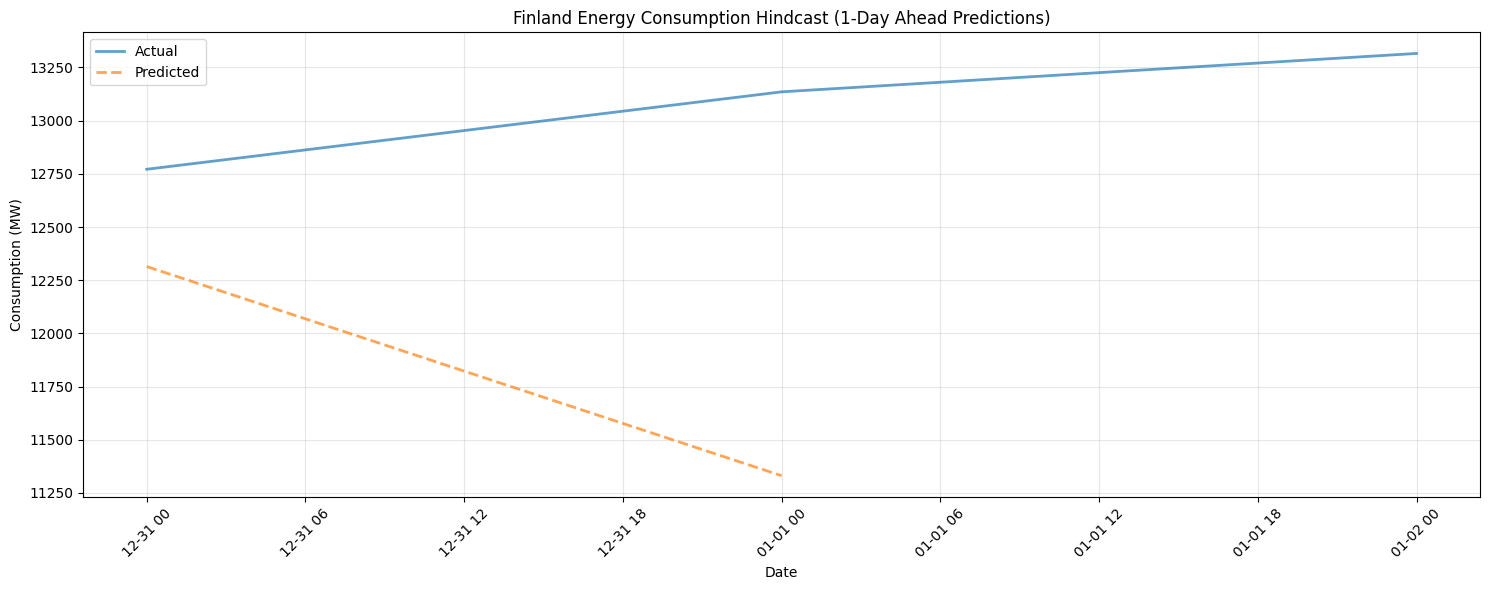

Hindcast saved to: c:\Users\patri\VScodeProjects\25-ID2223-mlfs-book\fingrid/docs/fingrid/assets/img/energy_hindcast.png


In [ ]:
plt.figure(figsize=(15, 6))

if len(hindcast_df) > 0:
    plt.plot(hindcast_df['date'], hindcast_df['actual_consumption'], 
             linewidth=2, alpha=0.7, label='Actual')
    plt.plot(hindcast_df['date'], hindcast_df['predicted_consumption'], 
             linewidth=2, alpha=0.7, label='Predicted', linestyle='--')
else:
    plt.text(0.5, 0.5, 'Waiting for historical data...', 
             ha='center', va='center', transform=plt.gca().transAxes, fontsize=14)

plt.xlabel('Date')
plt.ylabel('Consumption (MW)')
plt.title('Finland Energy Consumption Hindcast (1-Day Ahead Predictions)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()

# Save plot
hindcast_file_path = f"{root_dir}/docs/fingrid/assets/img/energy_hindcast.png"
os.makedirs(os.path.dirname(hindcast_file_path), exist_ok=True)
plt.savefig(hindcast_file_path, dpi=150, bbox_inches='tight')
plt.show()

print(f"Hindcast saved to: {hindcast_file_path}")

### Upload the prediction and hindcast dashboards (png files) to Hopsworks

In [ ]:
dataset_api = project.get_dataset_api()
str_today = today.strftime("%Y-%m-%d")
if dataset_api.exists("Resources/fingrid") == False:
    dataset_api.mkdir("Resources/fingrid")
dataset_api.upload(pred_file_path, f"Resources/fingrid/{country}_{city}_{str_today}", overwrite=True)
dataset_api.upload(hindcast_file_path, f"Resources/fingrid/{country}_{city}_{str_today}", overwrite=True)

proj_url = project.get_url()
print(f"See images in Hopsworks here: {proj_url}/settings/fb/path/Resources/fingrid")

Uploading c:\Users\patri\VScodeProjects\25-ID2223-mlfs-book\fingrid/docs/fingrid/assets/img/energy_forecast.pn…

Uploading c:\Users\patri\VScodeProjects\25-ID2223-mlfs-book\fingrid/docs/fingrid/assets/img/energy_hindcast.pn…

See images in Hopsworks here: https://c.app.hopsworks.ai:443/p/1286359/settings/fb/path/Resources/fingrid
